In [4]:
random_state = 42 # notebook consistency

from collections import Counter
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import os

import math
from tqdm import tqdm
import time

from scipy.cluster.hierarchy import linkage, fcluster

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from umap import UMAP
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import silhouette_score

from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

## Load data
cwd = os.getcwd()
os.chdir('..')
from scripts.consensus_matrix import *
from scripts.utils import *
from scripts.silhouette import *
df = pd.read_csv('BRCA_data.csv')

os.chdir(cwd)

sample_name = df.iloc[:,0].copy()    # sample index
X = df.iloc[:,1:354].copy()          # X : gene expression features
y = df.iloc[:,354:].copy()           # y : clinical labels

## Fit UMAP
umap_model = UMAP(
    n_neighbors=10,
    n_components=2,
    min_dist=0.1,
    metric="euclidean",
    random_state=random_state,
    n_jobs=1
)
X_umap = make_pipeline(umap_model).fit_transform(X)

## Silhouette Score

In [2]:
m = 15
df = silhouette_sweep(
    X_umap, 
    K_values=range(2, m+1),
    linkages=["ward", "average", "complete", "single"],
    random_state=random_state
)
print(df.head(7))

                    method  param  silhouette
0                   KMeans      2    0.504076
1                 Spectral      2    0.251774
2                      GMM      2    0.498931
3      Hierarchical | Ward      2    0.448724
4   Hierarchical | Average      2    0.514595
5  Hierarchical | Complete      2    0.502151
6    Hierarchical | Single      2    0.251774


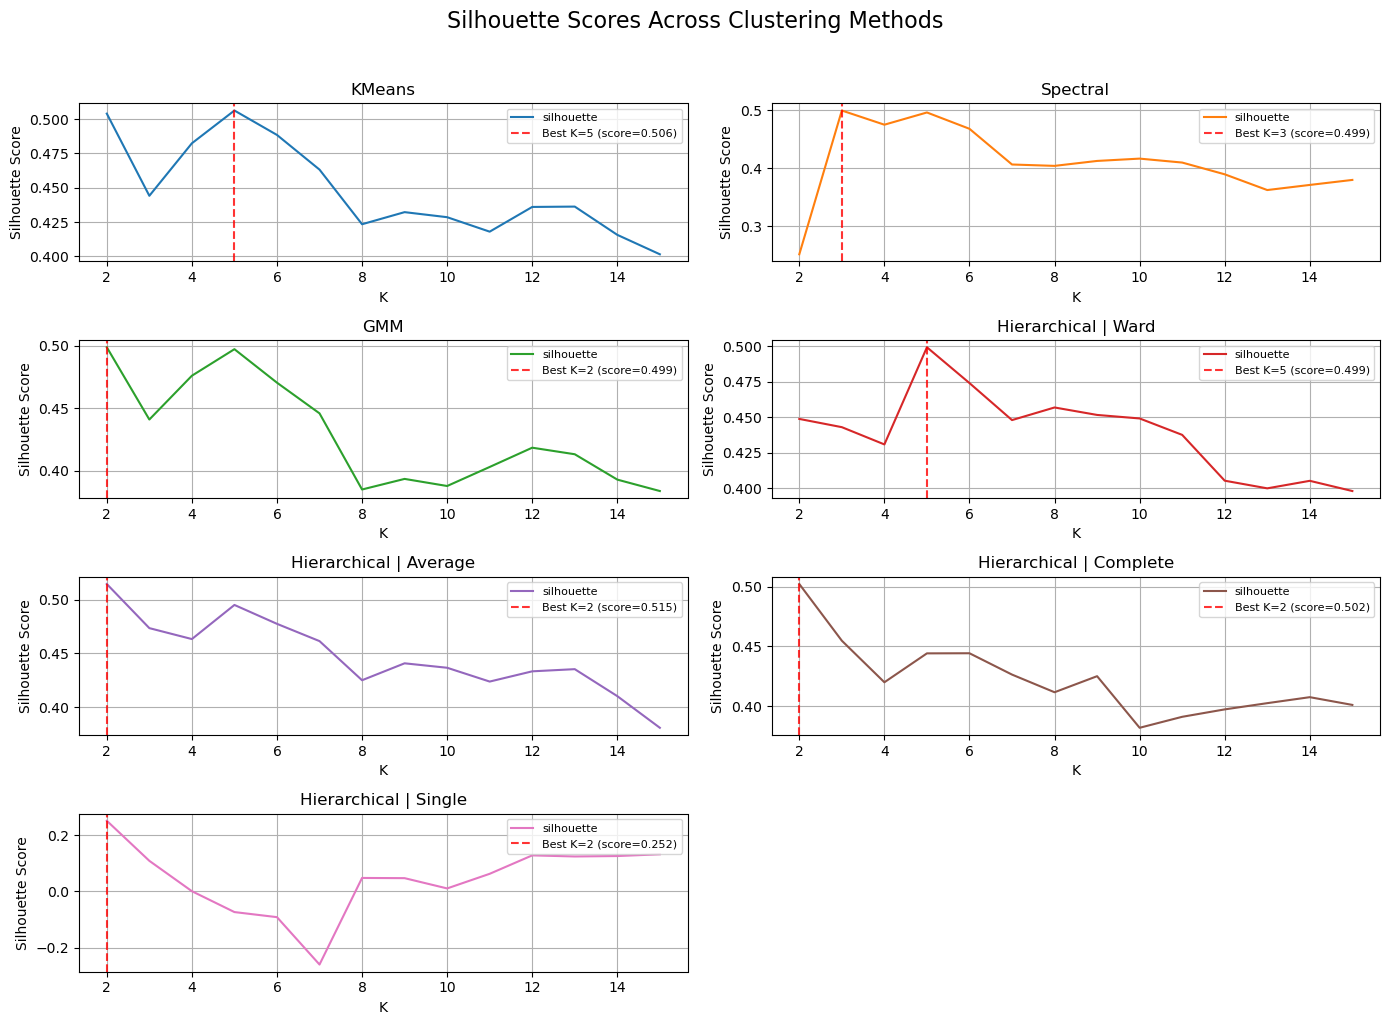

In [3]:
method_list = df['method'].unique()
n = len(method_list)

nrows, ncols = 4, 2
cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(n)]

fig, axes = plt.subplots(nrows, ncols, figsize=(7 * ncols, 2.5 * nrows))
axes = axes.flatten()

for i, method in enumerate(method_list):
    df_method = df.loc[df['method'] == method, ['param', 'silhouette']].set_index('param')
    color = colors[i % len(colors)]
    df_method.plot(ax=axes[i], grid=True, color=color, legend=False)
    axes[i].set_title(method)
    axes[i].set_xlabel("K")
    axes[i].set_ylabel("Silhouette Score")

    best_k = df_method['silhouette'].idxmax()
    best_score = df_method['silhouette'].max()

    axes[i].axvline(best_k, color='red', linestyle='--', alpha=0.8,
                    label=f'Best K={best_k} (score={best_score:.3f})')
    axes[i].legend(frameon=True, fontsize=8, loc='best')

for j in range(len(method_list), nrows * ncols):
    fig.delaxes(axes[j])

fig.suptitle("Silhouette Scores Across Clustering Methods", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

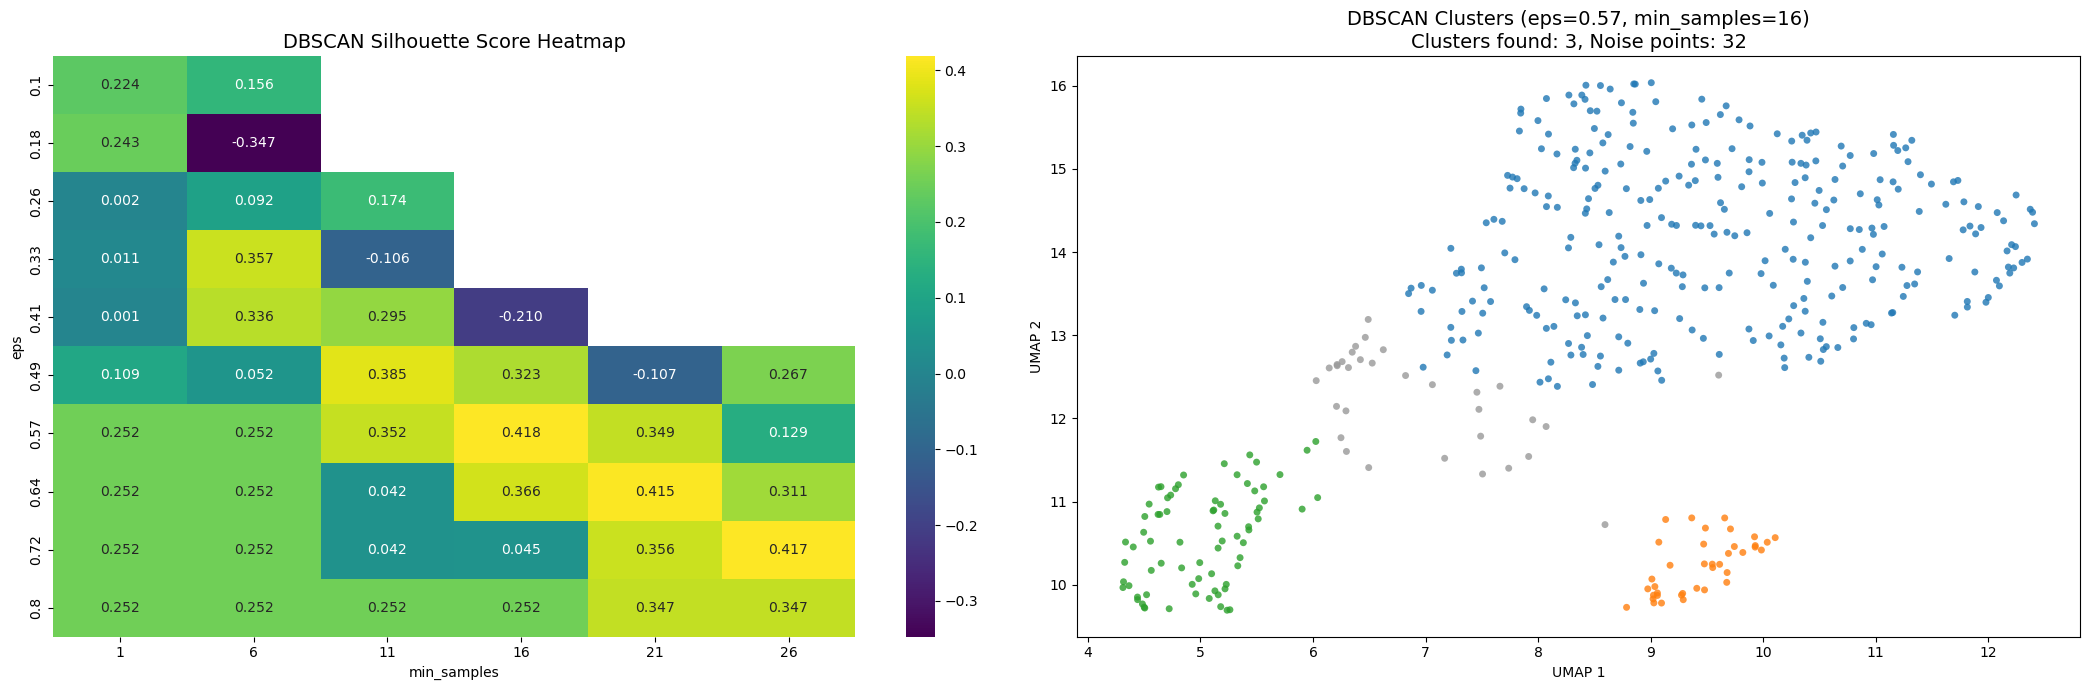

In [13]:
# Compute silhouette scores
df_dbscan = dbscan_silhouette_grid(
    X_umap,
    eps_values=np.linspace(0.1, 0.8, 10),
    min_samples_values=list(range(1, 31,5))
)

# Pivot to 2D matrix for heatmap
pivot_df = df_dbscan.pivot(index='eps', columns='min_samples', values='silhouette')

best_idx = np.unravel_index(np.nanargmax(pivot_df.values), pivot_df.shape)
best_eps = pivot_df.index[best_idx[0]]
best_ms = pivot_df.columns[best_idx[1]]
best_score = pivot_df.values[best_idx]

# Plot
fig, axes = plt.subplots(1,2, figsize=(21, 7))

## [0,0]
sns.heatmap(
    pivot_df,
    annot=True, fmt=".3f", cmap="viridis",
    xticklabels=pivot_df.columns,
    yticklabels=[round(e, 2) for e in pivot_df.index],
    ax=axes[0]
)
axes[0].set_title("DBSCAN Silhouette Score Heatmap", fontsize=14)
axes[0].set_xlabel("min_samples")
axes[0].set_ylabel("eps")

## [0,1]
best_model = DBSCAN(eps=round(best_eps,2), min_samples=best_ms).fit(X_umap)
Counter(best_model.labels_)
best_model.fit_predict(X_umap)
labels = best_model.labels_
unique_labels = np.unique(labels)
n_clusters = len(unique_labels[unique_labels != -1])
n_noise = np.sum(labels == -1)
palette = sns.color_palette("tab10", n_clusters)
colors = [palette[l] if l != -1 else (0.6, 0.6, 0.6) for l in labels]

axes[1].scatter(
    X_umap[:, 0],
    X_umap[:, 1],
    c=colors,
    s=25,
    alpha=0.8,
    edgecolor="none"
)

axes[1].set_title(
    f"DBSCAN Clusters (eps={best_model.eps}, min_samples={best_model.min_samples})\n"
    f"Clusters found: {n_clusters}, Noise points: {n_noise}",
    fontsize=14
)
axes[1].set_xlabel("UMAP 1")
axes[1].set_ylabel("UMAP 2")

plt.tight_layout()
plt.show()

